# Step 7: differential expression

In [1]:
.libPaths(new=c('/home/jthomp02/R410_manual', '/home/jthomp02/miniconda3/envs/Rv4_1/lib/R/library'))
suppressPackageStartupMessages({
    library(scater)
    library(Seurat) 
    library(SingleCellExperiment)
    library(MAST)
    library(dplyr)
    library(ggplot2)
    library(ggrepel)
})
set.seed(123)

In [7]:
(sca_sro_filt <- readRDS(here("processed-data","sca_sro_prefilt.rda")))

class: SingleCellAssay 
dim: 7904 5537 
metadata(0):
assays(3): counts norm logcounts
rownames(7904): Xkr4 Mrpl15 ... AC149090.1 tdt
rowData names(1): primerid
colnames(5537): AAACGCTAGGCTTTCA AAACGCTGTCACCACG ... TTTGTTGCAAATGAAC
  TTTGTTGGTAGAATAC
colData names(29): orig.ident nCount_RNA ... slingPseudotime_1
  pseudo1_bin
reducedDimNames(2): UMAP PCA
mainExpName: NULL
altExpNames(0):

# tdT by cluster

In [13]:
table(colData(sca_sro_filt)[,c("predicted.cluster","tdT")])

                       tdT
predicted.cluster       FALSE TRUE
  microglia                 0    0
  inf. macrophage           0    0
  mural 1                   0    0
  mural 2                   0    0
  endothelial               0    0
  astrocyte 1               0    0
  astrocyte 2               0    0
  RGL-like                  0    0
  olig 2                    0    0
  olig 1                    0    0
  olig precursor            0    0
  olig progenitor           0    0
  neuroprogenitor 1         0    0
  neuroprogenitor 2         0    0
  neuroprogenitor trans     0    0
  neuroblast 1              0    0
  neuroblast 2.1            0    0
  neuroblast 2.3            0    0
  neuroblast trans        778    2
  immature GC            1391  130
  GC 1                   1102 1230
  synaptic GC             166  738
  cajal-retzius             0    0

In [14]:
sca_filt_gc1 <- subset(sca_sro_filt, with(colData(sca_sro_filt), predicted.cluster=="GC 1"))
dim(sca_filt_gc1)
sca_filt_syn <- subset(sca_sro_filt, with(colData(sca_sro_filt), predicted.cluster=="synaptic GC"))
dim(sca_filt_syn)

[1] 7904 2332

[1] 7904  904

In [15]:
sca_list_clus = list("gc1"=sca_filt_gc1, "syn"=sca_filt_syn)

In [ ]:
for(i in 1:length(sca_list_clus)) {
    zlmCond_gc <- zlm(formula = ~condition + nFeature_SCT_scaled, 
                      sca=sca_list_clus[[i]], exprs_values='logcounts')
    summaryCond_gc <- summary(zlmCond_gc, logFC=TRUE, doLRT="conditionTRUE") 
    summaryDt <- summaryCond_gc$datatable
    fcHurdle <- merge(summaryDt[contrast=='conditionTRUE' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                      summaryDt[contrast=='conditionTRUE' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)],
                      by='primerid') %>% #logFC coefficients
        mutate(predictor="tdt.sct.2")
    fcHurdle[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    write.csv(fcHurdle, here("results",paste0("DEby_tdt_prefilt-genes_", names(sca_list_clus)[[i]],"-only.csv")))
}

In [23]:
deg.tdt.gc1 = read.csv(here("results","DEby_tdt_prefilt-genes_gc1-only.csv")_[,-1] %>% mutate(clus="gc1") %>% rowwise() %>% mutate(span0= sign(ci.hi)!=sign(ci.lo))
deg.tdt.syn = read.csv(here("results","DEby_tdt_prefilt-genes_syn-only.csv"))[,-1] %>% mutate(clus="syn") %>% rowwise() %>% mutate(span0= sign(ci.hi)!=sign(ci.lo))

In [24]:
deg.clus.list <- list(filter(deg.tdt.gc1, FDR<.0001 & coef>.1 & span0==FALSE) %>% pull(primerid),
                      filter(deg.tdt.gc1, FDR<.0001 & coef< -.1 & span0==FALSE) %>% pull(primerid),
                      filter(deg.tdt.syn, FDR<.0001 & coef>.1 & span0==FALSE) %>% pull(primerid),
                      filter(deg.tdt.syn, FDR<.0001 & coef< -.1 & span0==FALSE) %>% pull(primerid))
names(deg.clus.list) <- c("gc1.up","gc1.down","syn.up","syn.down")
deg.clus.list <- lapply(deg.clus.list, setdiff, y="tdt")
tdt.both.clus <- intersect(deg.clus.list$gc1.up, deg.clus.list$syn.up)
length(tdt.both.clus)
tdt.both.down <- intersect(deg.clus.list$gc1.down, deg.clus.list$syn.down)
length(tdt.both.down)

[1] 15

[1] 26

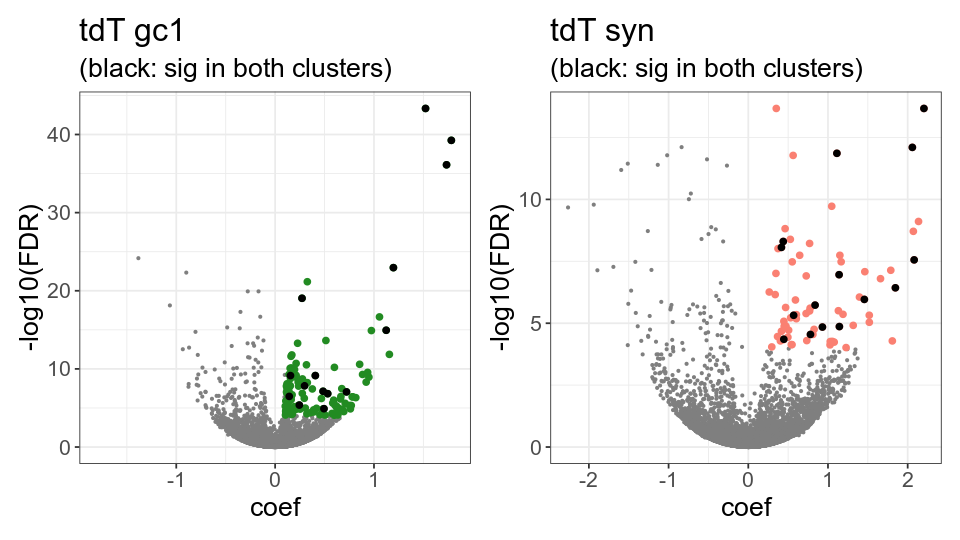

In [31]:
options(repr.plot.width=8, repr.plot.height=4.5)
p1 <- ggplot(filter(deg.tdt.gc1, primerid!="tdt"), aes(coef, -log10(FDR)))+
    geom_point(color="grey50", cex=.5)+
    geom_point(data=filter(deg.tdt.gc1, primerid %in% deg.clus.list$gc1.up), color="forestgreen")+
    geom_point(data=filter(deg.tdt.gc1, primerid %in% tdt.both.clus), color="black")+
    theme_bw()+
    xlim(-1.8,1.8)+
    labs(title="tdT gc1", subtitle="(black: sig in both clusters)")+
    theme(text= element_text(size=16))
p2 <- ggplot(filter(deg.tdt.syn, primerid!="tdt"), aes(coef, -log10(FDR)))+
    geom_point(color="grey50", cex=.5)+
    geom_point(data=filter(deg.tdt.syn, primerid %in% deg.clus.list$syn.up), color="salmon")+
    geom_point(data=filter(deg.tdt.syn, primerid %in% tdt.both.clus), color="black")+
    theme_bw()+
    labs(title="tdT syn", subtitle="(black: sig in both clusters)")+
    theme(text= element_text(size=16))
p1|p2

### GSEA of tdT by cluster DEGs

In [2]:
suppressPackageStartupMessages({
    library(org.Mm.eg.db)
    library(clusterProfiler)
    library(enrichplot)
    library(ggnewscale)
})

In [33]:
sro_filt <- readRDS(here("processed-data","sro_filt_norm.rda"))
universe_entrez = mapIds(org.Mm.eg.db,
                    keys=rownames(sro_filt), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="SYMBOL",
                    multiVals="first")
universe_entrez = universe_entrez[!is.na(universe_entrez)]
length(universe_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 19025

In [43]:
gc1_entrez = mapIds(org.Mm.eg.db,
                    keys=deg.clus.list$gc1.up, #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="SYMBOL",
                    multiVals="first")
gc1_entrez <- gc1_entrez[!is.na(gc1_entrez)]
length(gc1_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 111

In [44]:
gc1_results <- simplify(enrichGO(gc1_entrez, "org.Mm.eg.db", 
                                    keyType = "ENTREZID", ont="BP", universe= universe_entrez, 
                                    pAdjustMethod="fdr"))
nrow(gc1_results) #15

[1] 15

In [45]:
gc1_results <- setReadable(gc1_results, 'org.Mm.eg.db', 'ENTREZID')
gc1_results@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006119,GO:0006119,oxidative phosphorylation,16/105,93/17477,2.288126e-19,1.786692e-16,1.673664e-16,Atp5e/Atp5h/Atp5j/Atp5j2/Atp5k/Chchd10/Cox4i1/Cox5b/Cox7c/Cycs/Ndufa7/Ndufb8/Ndufs6/Ndufv1/Park7/Uqcc2,16
GO:0046034,GO:0046034,ATP metabolic process,21/105,227/17477,2.327937e-19,1.786692e-16,1.673664e-16,Aldoa/Atp5e/Atp5g2/Atp5g3/Atp5h/Atp5j/Atp5j2/Atp5k/Atpif1/Chchd10/Cox4i1/Cox5b/Cox7c/Cycs/Ndufa7/Ndufb8/Ndufs6/Ndufv1/Park7/Pkm/Uqcc2,21
GO:0009060,GO:0009060,aerobic respiration,16/105,138/17477,1.619020e-16,8.283984e-14,7.759933e-14,Atp5e/Atp5h/Atp5j/Atp5j2/Atp5k/Chchd10/Cox4i1/Cox5b/Cox7c/Cycs/Ndufa7/Ndufb8/Ndufs6/Ndufv1/Park7/Uqcc2,16
GO:0010257,GO:0010257,NADH dehydrogenase complex assembly,11/105,49/17477,5.183510e-15,1.136670e-12,1.064763e-12,Ndufa11/Ndufa2/Ndufa5/Ndufb10/Ndufb3/Ndufb4/Ndufb7/Ndufb8/Ndufc1/Ndufs5/Ndufs6,11
GO:0032981,GO:0032981,mitochondrial respiratory chain complex I assembly,11/105,49/17477,5.183510e-15,1.136670e-12,1.064763e-12,Ndufa11/Ndufa2/Ndufa5/Ndufb10/Ndufb3/Ndufb4/Ndufb7/Ndufb8/Ndufc1/Ndufs5/Ndufs6,11
GO:0015985,GO:0015985,"energy coupled proton transport, down electrochemical gradient",7/105,16/17477,2.523864e-12,3.228443e-10,3.024209e-10,Atp5e/Atp5g2/Atp5g3/Atp5h/Atp5j/Atp5j2/Atp5k,7
GO:0015986,GO:0015986,ATP synthesis coupled proton transport,7/105,16/17477,2.523864e-12,3.228443e-10,3.024209e-10,Atp5e/Atp5g2/Atp5g3/Atp5h/Atp5j/Atp5j2/Atp5k,7
GO:0007005,GO:0007005,mitochondrion organization,16/105,482/17477,2.865888e-08,1.571121e-06,1.471730e-06,Atpif1/Chchd10/Gabarap/Ndufa11/Ndufa2/Ndufa5/Ndufb10/Ndufb3/Ndufb4/Ndufb7/Ndufb8/Ndufc1/Ndufs5/Ndufs6/Park7/Uqcc2,16
GO:0046390,GO:0046390,ribose phosphate biosynthetic process,9/105,155/17477,3.911788e-07,1.819574e-05,1.704466e-05,Aldoa/Atp5e/Atp5g2/Atp5g3/Atp5h/Atp5j/Atp5j2/Atp5k/Pkm,9


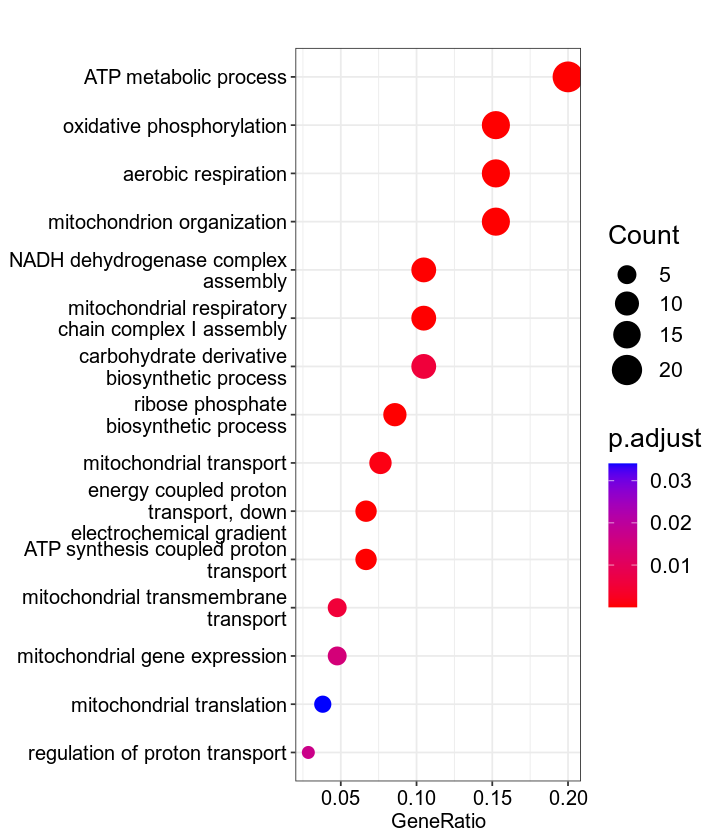

In [46]:
options(repr.plot.width=6, repr.plot.height=7)
dotplot(gc1_results, showCategory=15)+theme(text=element_text(size=16))

In [47]:
syn_entrez = mapIds(org.Mm.eg.db,
                    keys=deg.clus.list$syn.up, #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="SYMBOL",
                    multiVals="first")
syn_entrez <- syn_entrez[!is.na(syn_entrez)]
length(syn_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 65

In [48]:
syn_results <- simplify(enrichGO(syn_entrez, "org.Mm.eg.db", 
                                    keyType = "ENTREZID", ont="BP", universe= universe_entrez, 
                                    pAdjustMethod="fdr"))
nrow(syn_results) #4

[1] 4

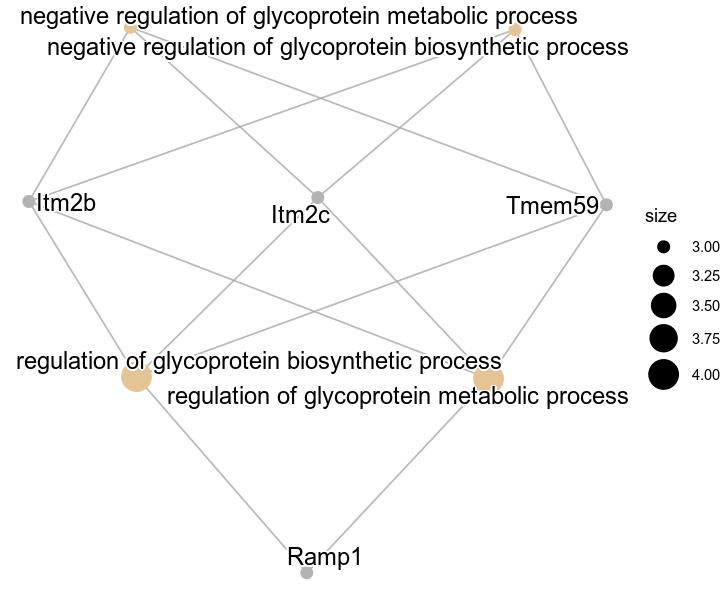

In [49]:
syn_results <- setReadable(syn_results, 'org.Mm.eg.db', 'ENTREZID')
options(repr.plot.width=6, repr.plot.height=5)
cnetplot(syn_results)

# tdT by age

In [8]:
table(colData(sca_sro_filt)[,c("Age_group","tdT")])

         tdT
Age_group FALSE TRUE
       14  1013  121
       20  1326  722
       24  1098 1257

In [9]:
cond<-factor(colData(sca_sro_filt)$tdT)
cond<-relevel(cond,"FALSE")
colData(sca_sro_filt)$condition<-cond
colData(sca_sro_filt)$nFeature_SCT_scaled <- scale(colData(sca_sro_filt)$nFeature_SCT)

In [10]:
sca_filt_p14 <- subset(sca_sro_filt, with(colData(sca_sro_filt), Age_group=="14"))
dim(sca_filt_p14)
sca_filt_p20 <- subset(sca_sro_filt, with(colData(sca_sro_filt), Age_group=="20"))
dim(sca_filt_p20)
sca_filt_p24 <- subset(sca_sro_filt, with(colData(sca_sro_filt), Age_group=="24"))
dim(sca_filt_p24)

[1] 7904 1134

[1] 7904 2048

[1] 7904 2355

In [11]:
sca_list_ages = list("p14"=sca_filt_p14, "p20"=sca_filt_p20, "p24"=sca_filt_p24)

In [ ]:
for(i in 1:length(sca_list_ages)) {
    zlmCond_gc <- zlm(formula = ~condition + nFeature_SCT_scaled, 
                      sca=sca_list_ages[[i]], exprs_values='logcounts')
    summaryCond_gc <- summary(zlmCond_gc, logFC=TRUE, doLRT="conditionTRUE") 
    summaryDt <- summaryCond_gc$datatable
    fcHurdle <- merge(summaryDt[contrast=='conditionTRUE' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                      summaryDt[contrast=='conditionTRUE' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)],
                      by='primerid') %>% #logFC coefficients
        mutate(predictor="tdt.sct.2")
    fcHurdle[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    write.csv(fcHurdle, paste0(here("results","DEby_tdt_prefilt-genes_", names(sca_list_ages)[[i]],"-gcs.csv")))
}

In [17]:
deg.tdt.p14 <- read.csv(here("results","DEby_tdt_prefilt-genes_p14-gcs.csv"))[,-1] %>% mutate(age="P14") %>% rowwise() %>% mutate(span0= sign(ci.hi)!=sign(ci.lo))
deg.tdt.p20 <- read.csv(here("results","DEby_tdt_prefilt-genes_p20-gcs.csv"))[,-1] %>% mutate(age="P20") %>% rowwise() %>% mutate(span0= sign(ci.hi)!=sign(ci.lo))
deg.tdt.p24 <- read.csv(here("results","DEby_tdt_prefilt-genes_p24-gcs.csv"))[,-1] %>% mutate(age="P24") %>% rowwise() %>% mutate(span0= sign(ci.hi)!=sign(ci.lo))

In [18]:
deg.tdt.list <- list(filter(deg.tdt.p14, FDR<.0001 & coef>.3 & span0==FALSE) %>% pull(primerid),
              filter(deg.tdt.p14, FDR<.0001 & coef< -.3 & span0==FALSE) %>% pull(primerid),
             filter(deg.tdt.p20, FDR<.0001 & coef>.3 & span0==FALSE) %>% pull(primerid),
              filter(deg.tdt.p20, FDR<.0001 & coef< -.3 & span0==FALSE) %>% pull(primerid),
             filter(deg.tdt.p24, FDR<.0001 & coef>.3 & span0==FALSE) %>% pull(primerid),
             filter(deg.tdt.p24, FDR<.0001 & coef< -.3 & span0==FALSE) %>% pull(primerid))
names(deg.tdt.list) <- c("p14.up","p14.down","p20.up","p20.down","p24.up","p24.down")
deg.tdt.list <- lapply(deg.tdt.list, setdiff, y="tdt")
tdt.all.ages = intersect(intersect(deg.tdt.list$p14.up, deg.tdt.list$p20.up),deg.tdt.list$p24.up)
length(tdt.all.ages)
tdt.ages.down = intersect(intersect(deg.tdt.list$p14.down, deg.tdt.list$p20.down),deg.tdt.list$p24.down)
length(tdt.ages.down)

[1] 245

[1] 250

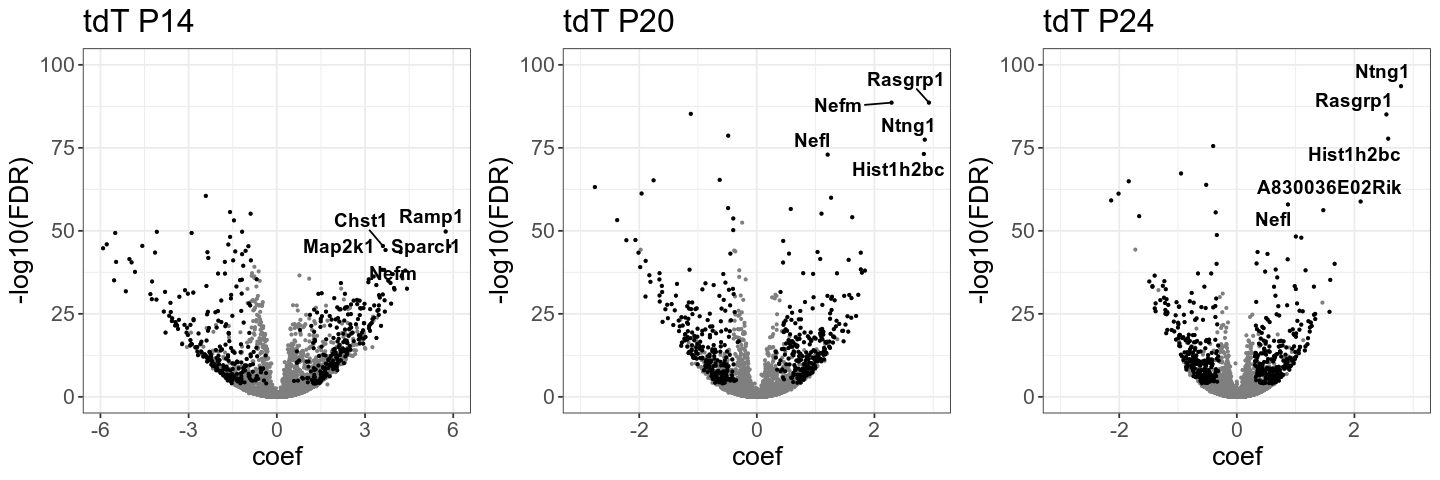

In [22]:
options(repr.plot.width=12, repr.plot.height=4)
p1 <- ggplot(filter(deg.tdt.p14, primerid!="tdt"), aes(coef, -log10(FDR)))+
    geom_point(color="grey50", cex=.5)+
    geom_point(data=filter(deg.tdt.p14, primerid %in% c(tdt.all.ages, tdt.ages.down)), color="black", cex=.5)+
    theme_bw()+
        geom_text_repel(data = filter(as.data.frame(deg.tdt.p14), primerid%in% tdt.all.ages) %>%
                        top_n(-5,FDR), aes(label=primerid),
                    force = 10,
                        fontface="bold",
                    max.overlaps= 15,
                    size = 4) +
    xlim(-6,6)+
    ylim(0,100)+
    ggtitle("tdT P14")+
    theme(text= element_text(size=16))
p2 <- ggplot(filter(deg.tdt.p20, primerid!="tdt"), aes(coef, -log10(FDR)))+
    geom_point(color="grey50", cex=.5)+
    geom_point(data=filter(deg.tdt.p20, primerid %in% c(tdt.all.ages, tdt.ages.down)), color="black", cex=.5)+
    theme_bw()+
        geom_text_repel(data = filter(as.data.frame(deg.tdt.p20), primerid %in% tdt.all.ages) %>%
                        top_n(-5,FDR), aes(label=primerid),
                    force = 5,
                        fontface="bold",
                    max.overlaps= 15,
                    size = 4) +
    xlim(-3,3)+
    ylim(0,100)+
    ggtitle("tdT P20")+
    theme(text= element_text(size=16))
p3 <- ggplot(filter(deg.tdt.p24, primerid!="tdt"), aes(coef, -log10(FDR)))+
    geom_point(color="grey50", cex=.5)+
    geom_point(data=filter(deg.tdt.p24, primerid %in% c(tdt.all.ages, tdt.ages.down)), color="black", cex=.5)+
    theme_bw()+
        geom_text_repel(data = filter(as.data.frame(deg.tdt.p24), primerid%in% tdt.all.ages) %>%
                        top_n(-5,FDR), aes(label=primerid),
                    force = 10,
                    fontface="bold",
                    max.overlaps= 15,
                        size = 4) +
    xlim(-3,3)+
    ylim(0,100)+
    ggtitle("tdT P24")+
    theme(text= element_text(size=16))
cowplot::plot_grid(p1, p2 ,p3, ncol=3)

### GSEA of tdT by age DEGs

In [34]:
tdt_entrez = mapIds(org.Mm.eg.db,
                    keys=tdt.all.ages, #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="SYMBOL",
                    multiVals="first")
tdt_entrez <- tdt_entrez[!is.na(tdt_entrez)]
length(tdt_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 233

In [35]:
tdt_results <- simplify(enrichGO(tdt_entrez, "org.Mm.eg.db", 
                                    keyType = "ENTREZID", ont="BP", universe= universe_entrez, 
                                    pAdjustMethod="fdr"))
nrow(tdt_results) #55

[1] 55

In [36]:
tdt_results <- setReadable(tdt_results, 'org.Mm.eg.db', 'ENTREZID')
tdt_results@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050808,GO:0050808,synapse organization,24/219,475/17477,7.120791e-09,1.961778e-05,1.731477e-05,Atp2b2/Chchd10/Cnksr2/Dgkb/Dgkz/Gabra1/Gabrg2/Gpc4/Grin2a/Itpka/Myo5b/Nefl/Nos1ap/Nrcam/Nrxn3/Ntng1/Pcdh17/Prkca/Prnp/Slitrk1/Sparcl1/Tanc1/Wasl/Zfp365,24
GO:0034765,GO:0034765,regulation of ion transmembrane transport,23/219,462/17477,1.969590e-08,2.713110e-05,2.394607e-05,Atp1b1/Cacna2d1/Grin2a/Hpca/Hspa2/Kcnab1/Kcnb1/Kcnip4/Kcnj3/Kcnj4/Neto1/Nos1ap/Ppargc1a/Prkca/Prnp/Ptk2b/Ptpn3/Rasgrf1/Scn1b/Scn2b/Tgfb2/Tmem38a/Trpc6,23
GO:0010959,GO:0010959,regulation of metal ion transport,21/219,414/17477,6.147345e-08,3.387187e-05,2.989551e-05,Atp1a1/Atp1b1/Atp2b2/Cacna2d1/Homer2/Hpca/Hspa2/Kcnab1/Kcnip4/Neto1/Nos1ap/Prnp/Ptk2b/Ptpn3/Scn1b/Scn2b/Sgk1/Tgfb2/Tmem38a/Trpc6/Usp2,21
GO:0032409,GO:0032409,regulation of transporter activity,17/219,282/17477,1.034277e-07,4.749056e-05,4.191544e-05,Atp1b1/Cacna2d1/Grin2a/Hpca/Hspa2/Kcnab1/Neto1/Nos1ap/Ppargc1a/Prkca/Prnp/Ptk2b/Ptpn3/Rasgrf1/Scn1b/Scn2b/Trpc6,17
GO:0042391,GO:0042391,regulation of membrane potential,21/219,432/17477,1.259810e-07,4.958253e-05,4.376183e-05,Atp1a1/Atp1b1/Cacna2d1/Chchd10/Gabra1/Gabra4/Gabrb1/Gabrd/Gabrg2/Grin2a/Jun/Kcnb1/Mtch2/Neto1/Nos1ap/Nrcam/Ptk2b/Ptpn3/Scn1b/Scn2b/Slc17a7,21
GO:0098661,GO:0098661,inorganic anion transmembrane transport,8/219,70/17477,2.591040e-06,7.931461e-04,7.000353e-04,Ano3/Gabra1/Gabra4/Gabrb1/Gabrd/Gabrg2/Prnp/Slc25a14,8
GO:0007611,GO:0007611,learning or memory,15/219,295/17477,4.931143e-06,1.358530e-03,1.199046e-03,Adcy1/Grin2a/Jun/Kcnab1/Neto1/Nrxn3/Pde1b/Prkca/Prnp/Rgs14/Rin1/Sgk1/Slc17a7/Snap25/Tanc1,15
GO:0046034,GO:0046034,ATP metabolic process,12/219,227/17477,3.039255e-05,5.703260e-03,5.033731e-03,Aldoa/Atp1b1/Atp6v1a/Chchd10/Eno2/Gpi1/Map2k1/Mtch2/Ndufv1/Pfkl/Ppargc1a/Uqcc2,12
GO:0048167,GO:0048167,regulation of synaptic plasticity,12/219,229/17477,3.312238e-05,5.703260e-03,5.033731e-03,Adcy1/Atp2b2/Grin2a/Itpka/Kcnb1/Neto1/Prnp/Ptk2b/Rasgrf1/Rgs14/Rin1/Snap25,12


Warning message in if (n == 1) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


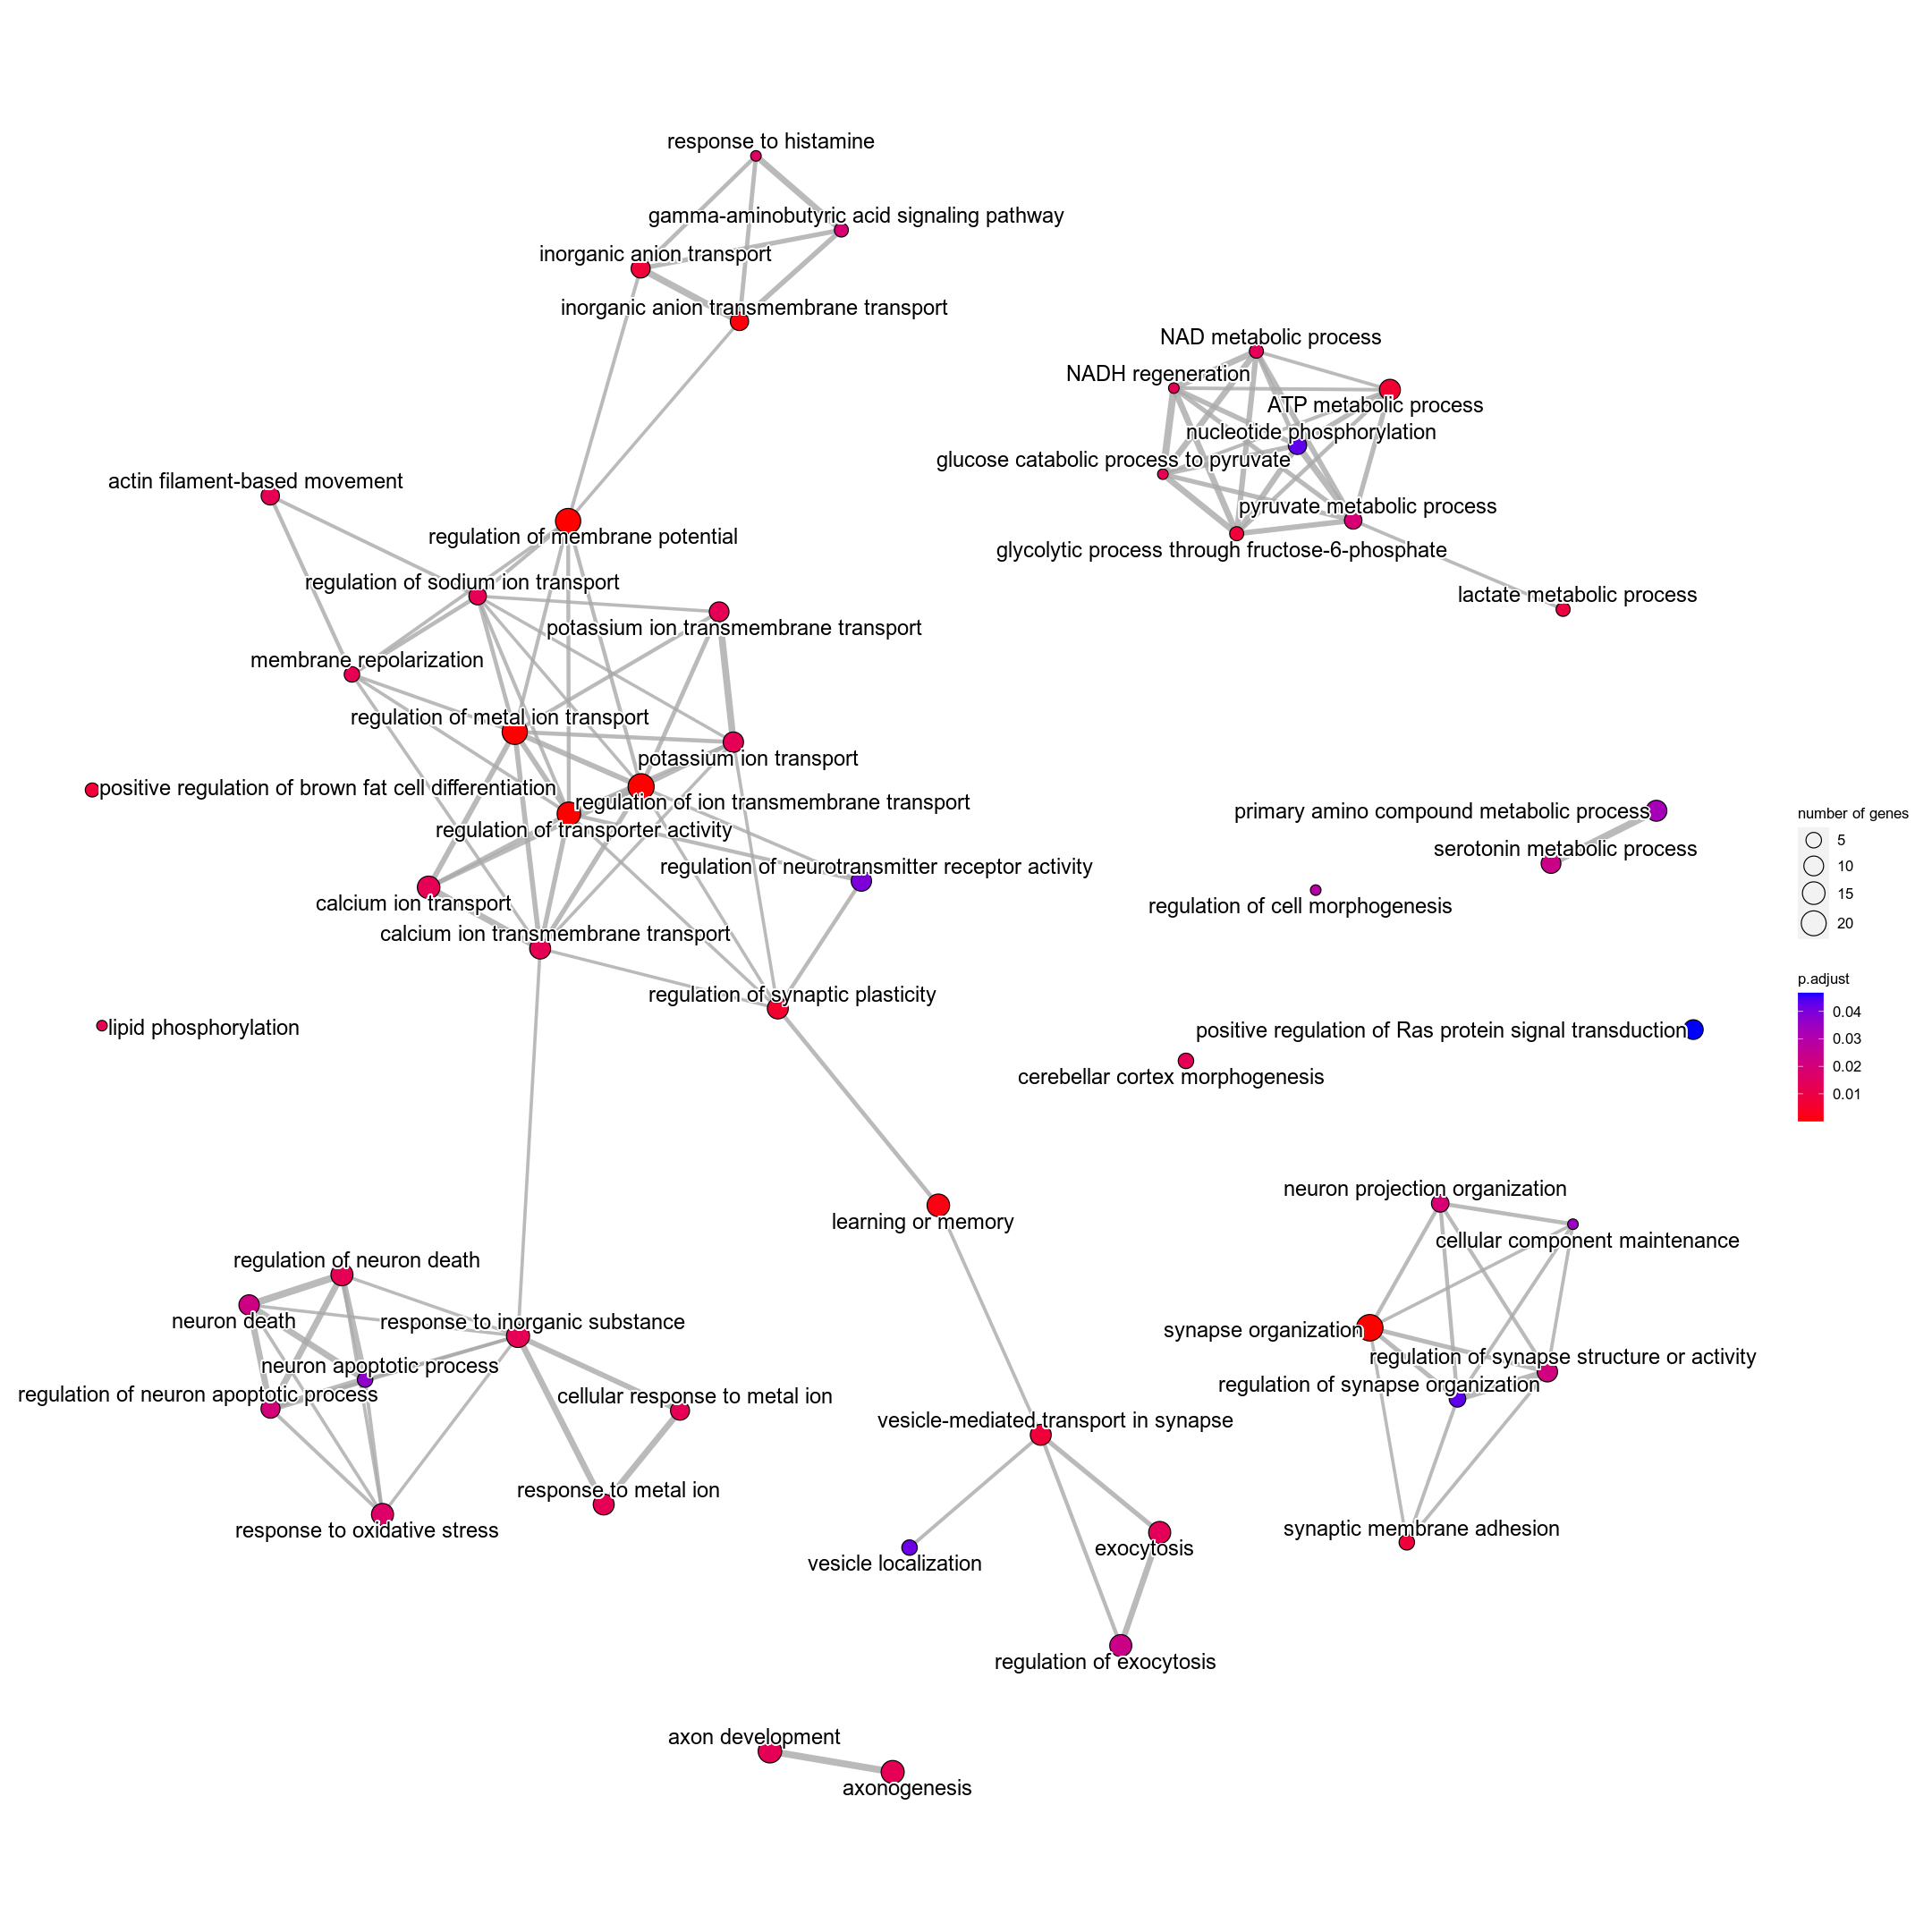

In [37]:
tdt_results <- pairwise_termsim(tdt_results)
options(repr.plot.width=18, repr.plot.height=18)
emapplot(tdt_results, showCategory=tdt_results$Description[-grep("heart",tdt_results$Description)], 
         node_scale=1, node_label="category", layout="fr")

In [38]:
neg_entrez = mapIds(org.Mm.eg.db,
                    keys=tdt.ages.down, #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="SYMBOL",
                    multiVals="first")
neg_entrez <- neg_entrez[!is.na(neg_entrez)]
length(neg_entrez)

'select()' returned 1:1 mapping between keys and columns



[1] 245

In [39]:
neg_results <- simplify(enrichGO(neg_entrez, "org.Mm.eg.db", 
                                    keyType = "ENTREZID", ont="BP", universe= universe_entrez, 
                                    pAdjustMethod="fdr"))
nrow(neg_results) #71

[1] 71

In [40]:
neg_results <- setReadable(neg_results, 'org.Mm.eg.db', 'ENTREZID')
neg_results@result

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007409,GO:0007409,axonogenesis,30/238,450/17477,6.504821e-13,1.777666e-09,1.547656e-09,Apc/Bhlhe22/Crmp1/Dcx/Dpysl2/Dpysl5/Gap43/Islr2/Klf7/L1cam/Macf1/Mapt/Nectin1/Nfib/Nrp1/Nrp2/Pak2/Pak3/Plxna2/Pten/Ptpro/Rnd2/Robo1/Sema4d/Sema5a/Sema6d/Shtn1/Top2b/Tubb2b/Tubb3,30
GO:0061564,GO:0061564,axon development,31/238,493/17477,1.212596e-12,1.777666e-09,1.547656e-09,Apc/Bhlhe22/Crmp1/Dcx/Dpysl2/Dpysl5/Gap43/Islr2/Klf7/L1cam/Macf1/Mapt/Nectin1/Nfib/Nrep/Nrp1/Nrp2/Pak2/Pak3/Plxna2/Pten/Ptpro/Rnd2/Robo1/Sema4d/Sema5a/Sema6d/Shtn1/Top2b/Tubb2b/Tubb3,31
GO:0031346,GO:0031346,positive regulation of cell projection organization,26/238,426/17477,1.741763e-10,1.702283e-07,1.482026e-07,Apc/Ccdc88a/Dcx/Dpysl3/Eps8/Fgfr1/Fscn1/Fut9/Fyn/Islr2/L1cam/Macf1/Mapt/Marcks/Nrp1/Pak3/Palm/Plppr5/Plxna2/Rnd2/Robo1/Sema4d/Sema5a/Shtn1/Stmn2/Tgfbr1,26
GO:0008361,GO:0008361,regulation of cell size,15/238,205/17477,1.433979e-07,4.973796e-05,4.330242e-05,Cdk4/Dcx/Dpysl2/Islr2/L1cam/Macf1/Mapt/Mtpn/Nrp1/Pten/Rnd2/Sema4d/Sema5a/Sema6d/Shtn1,15
GO:0061387,GO:0061387,regulation of extent of cell growth,12/238,126/17477,1.526745e-07,4.973796e-05,4.330242e-05,Dcx/Dpysl2/Islr2/L1cam/Macf1/Mapt/Nrp1/Rnd2/Sema4d/Sema5a/Sema6d/Shtn1,12
GO:0048638,GO:0048638,regulation of developmental growth,20/238,373/17477,2.048655e-07,6.006655e-05,5.229460e-05,Apc/Cdk4/Cxadr/Dcx/Dpysl2/Fgfr1/Islr2/L1cam/Macf1/Mapt/Nrp1/Prox1/Pten/Rnd2/Sema4d/Sema5a/Sema6d/Shtn1/Tgfbr1/Ybx3,20
GO:0007015,GO:0007015,actin filament organization,21/238,428/17477,4.376870e-07,1.066406e-04,9.284252e-05,Actg1/Ccdc88a/Dpysl3/Eps8/Fscn1/Marcks/Marcksl1/Mtpn/Nrp1/Pak2/Pak3/Prox1/Rac3/Rnd2/Samd14/Sema5a/Sh3kbp1/Shtn1/Tgfbr1/Tmsb10/Tpm3,21
GO:0048588,GO:0048588,developmental cell growth,16/238,257/17477,4.956186e-07,1.066406e-04,9.284252e-05,Akap13/Dcx/Dpysl2/Islr2/Kdm1a/L1cam/Macf1/Mapt/Nrp1/Nrp2/Prmt2/Rnd2/Sema4d/Sema5a/Sema6d/Shtn1,16
GO:0030900,GO:0030900,forebrain development,19/238,359/17477,5.091982e-07,1.066406e-04,9.284252e-05,Bhlhe22/Cntnap2/Dcx/Fgfr1/Fyn/Gnaq/Kdm1a/Neurod1/Nfib/Nrp1/Nrp2/Prox1/Pten/Rac3/Robo1/Sema5a/Srgap2/Top2b/Zbtb18,19


In [41]:
f1 <- neg_results$Description[-grep("heart", neg_results$Description)]
f2 <- f1[-grep("cardiac",f1)]
f3 <- f2[-grep("muscle",f2)]

Warning message in if (n == 1) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


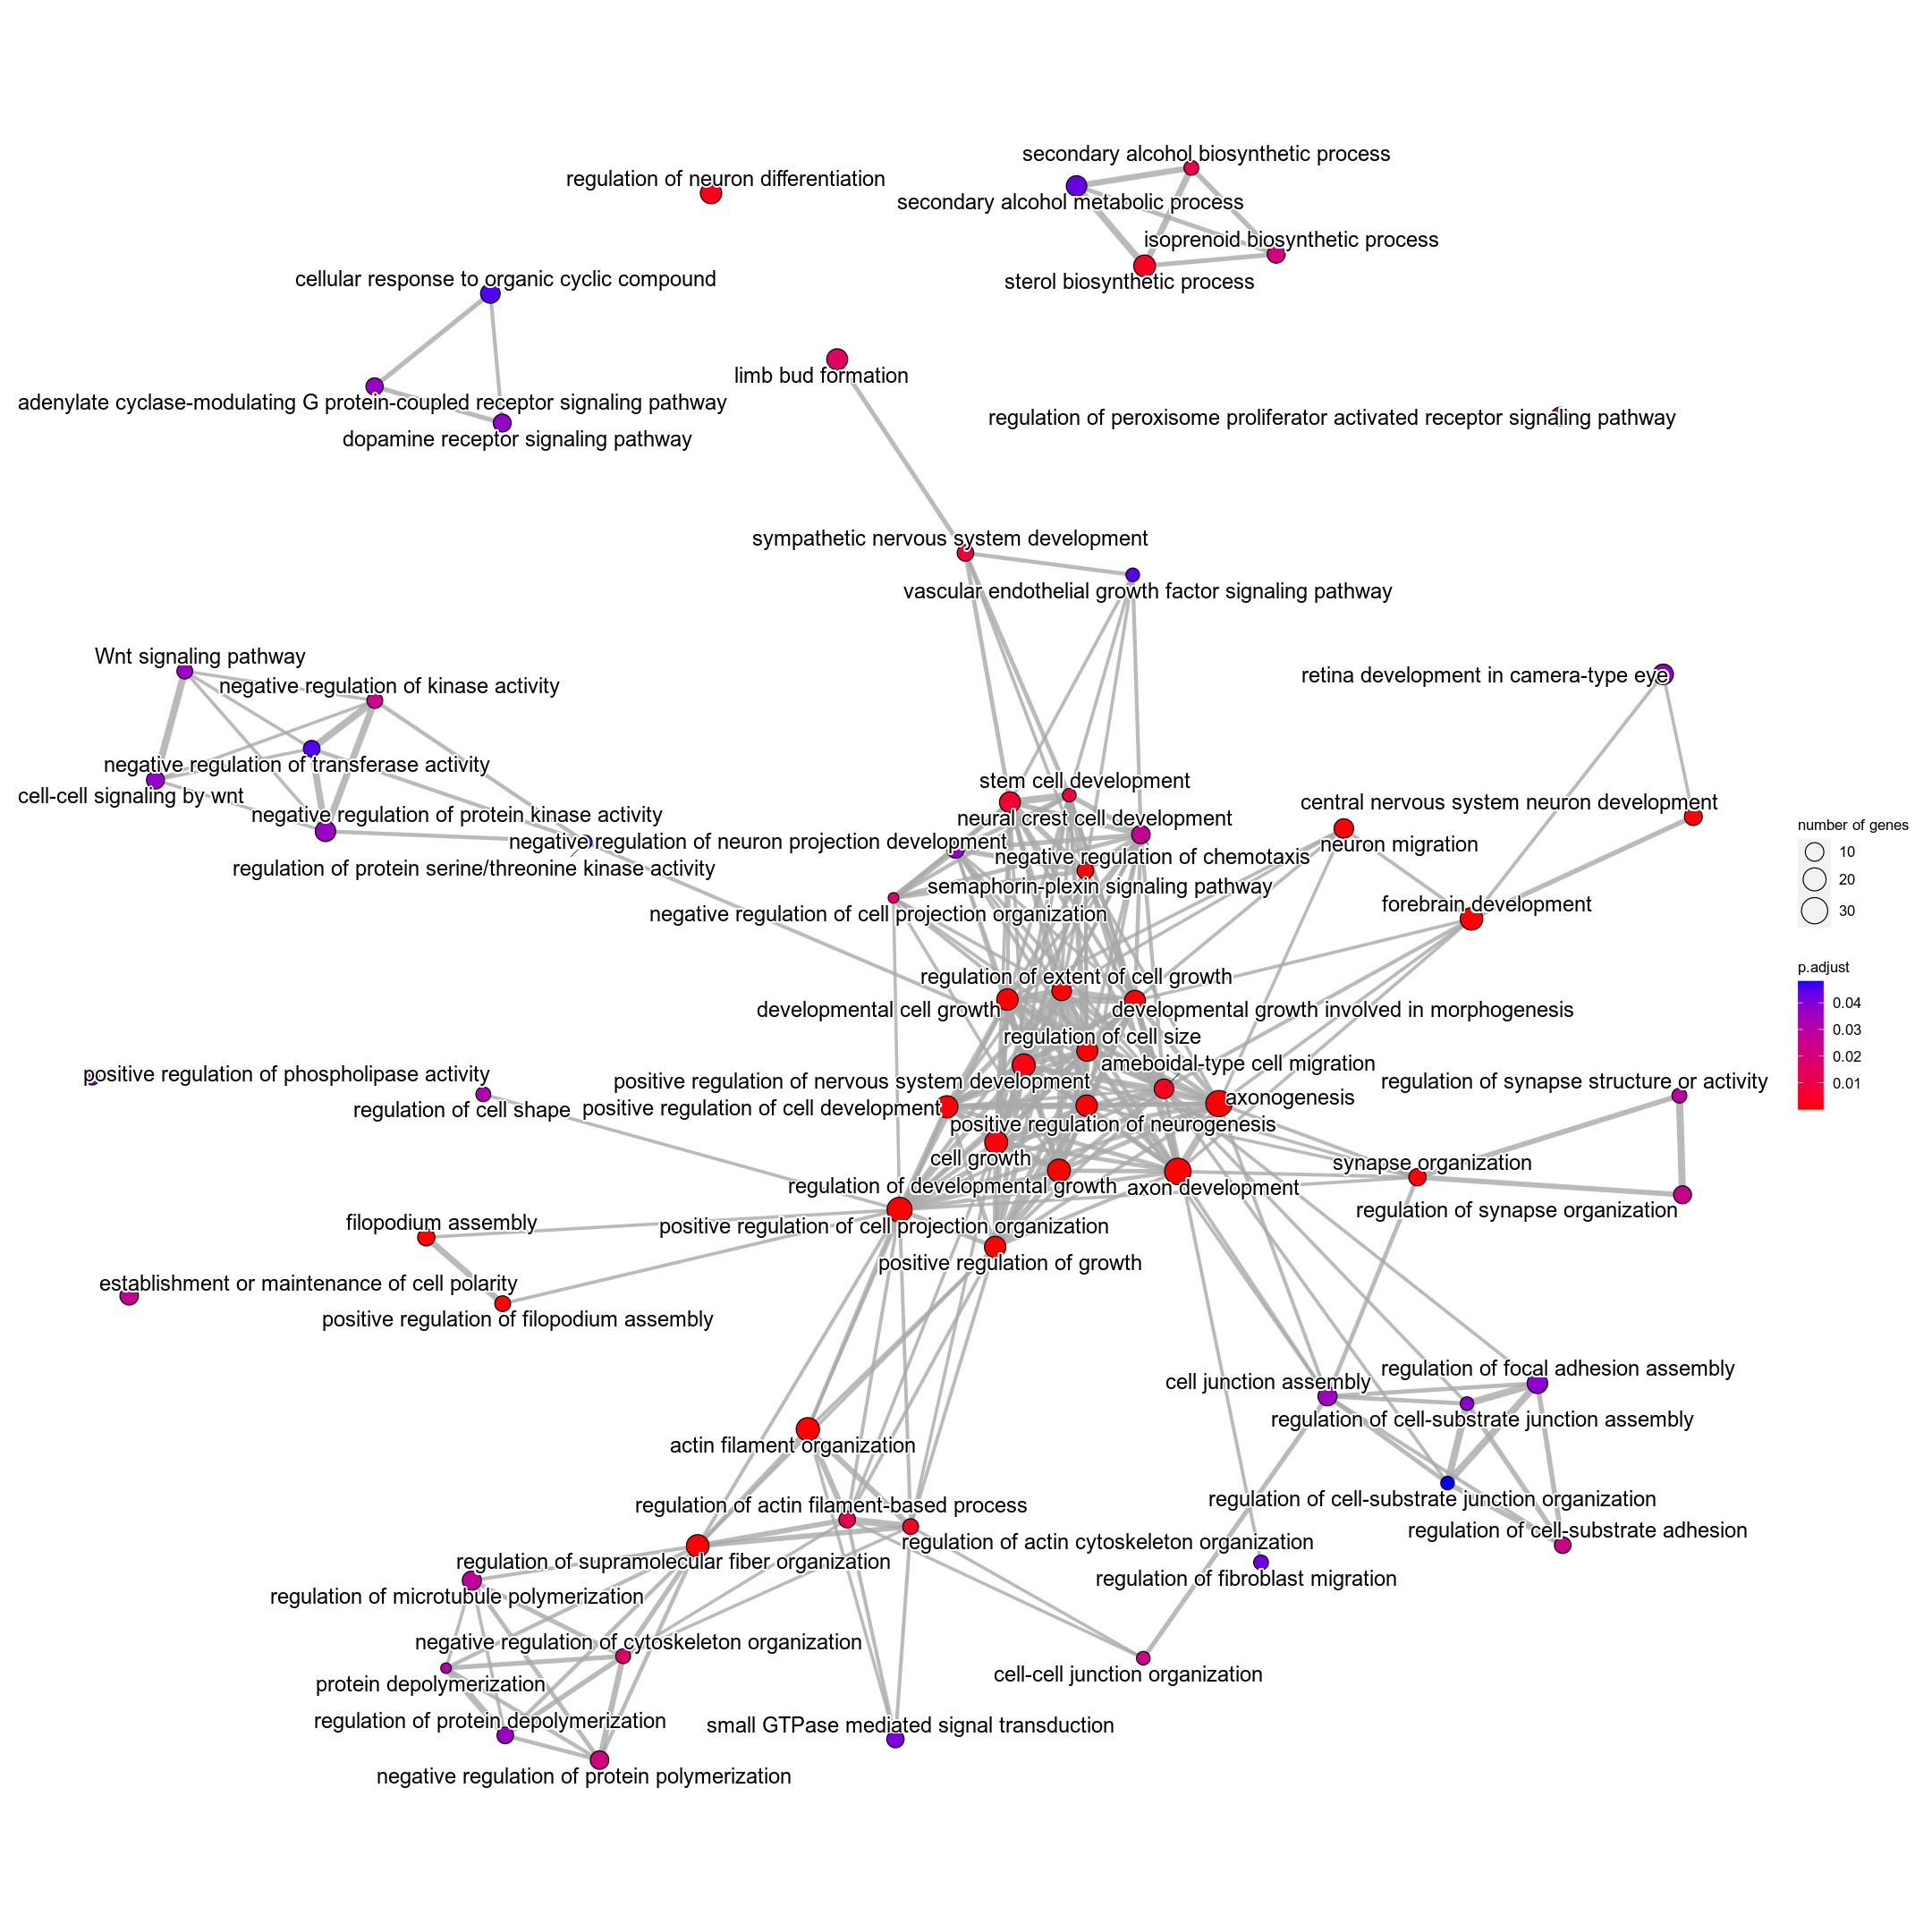

In [42]:
neg_results <- pairwise_termsim(neg_results)
options(repr.plot.width=18, repr.plot.height=18)
emapplot(neg_results, showCategory=f3, node_scale=1, node_label="category", layout="fr")